In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Setting up transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Loading the CIFAR-10 datasets
data_dir = './CIFAR10_data'
trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform)

# Assuming you start with a small labeled dataset and the rest is unlabeled
initial_train_size = 1000
unlabeled_size = len(trainset) - initial_train_size

trainset_labeled_indices = list(range(initial_train_size))
trainset_unlabeled_indices = list(range(initial_train_size, len(trainset)))

labeled_set = torch.utils.data.Subset(trainset, trainset_labeled_indices)
unlabeled_set = torch.utils.data.Subset(trainset, trainset_unlabeled_indices)

trainloader = torch.utils.data.DataLoader(labeled_set, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [2]:
# set seeds 
seed=42
random.seed(seed)  # Python
np.random.seed(seed)  # NumPy
torch.manual_seed(seed)  # PyTorch
torch.cuda.manual_seed_all(seed)  # PyTorch CUDA

In [3]:
class EnhancedCNN(nn.Module):
    def __init__(self):
        super(EnhancedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.bn4(self.fc1(x)))
        x = self.fc2(x)
        return x

In [4]:
def train_model(model, trainloader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    for epoch in range(epochs):
        running_loss = 0.0
        model.train()
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 200 == 199:
                print(f'[{epoch + 1}, {i + 1}]: loss: {running_loss / 200}')
                running_loss = 0.0
        scheduler.step()

    print('Finished Training')

In [5]:
def uncertainty_sampling(model, unlabeled_loader, n):
    model.eval()  # Set the model to evaluation mode
    
    uncertainties = []
    with torch.no_grad():  # No need to compute gradients
        for inputs, _ in unlabeled_loader:
            outputs = model(inputs)
            # We'll use entropy as a measure of uncertainty
            probabilities = F.softmax(outputs, dim=1)
            log_probabilities = F.log_softmax(outputs, dim=1)
            entropy = -(probabilities * log_probabilities).sum(dim=1)
            uncertainties.extend(entropy.tolist())
    
    # Get the indices of the top n uncertain samples
    uncertain_indices = np.argsort(uncertainties)[-n:]
    
    model.train()  # Set the model back to training mode
    return uncertain_indices

def random_sampling(n, unlabeled_set_size):
    # Randomly select n indices from the remaining unlabeled set
    random_indices = np.random.choice(range(unlabeled_set_size), size=n, replace=False)
    return random_indices

In [6]:
from torch.utils.data import DataLoader, Subset

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    model.train()
    return correct / total

## Teoretisk bedste:

In [7]:
# trainset_full = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
# testset = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform)

# # DataLoaders
# trainloader_full = DataLoader(trainset_full, batch_size=64, shuffle=True)
# testloader = DataLoader(testset, batch_size=64, shuffle=False)

# # Model Initialization
# model_full = EnhancedCNN()

# # Train the model on the full training set
# train_model(model_full, trainloader_full, epochs=10)  # Adjust epochs as needed

# # Evaluate the model on the test set
# accuracy_full = evaluate_model(model_full, testloader)
# print(f'Accuracy on the full CIFAR-10 test set: {accuracy_full*100:.2f}%')

In [8]:
accuracies = []

# Instantiate the enhanced model
model = EnhancedCNN()

# Reset the initial dataset split
trainset_labeled_indices = list(range(initial_train_size))
trainset_unlabeled_indices = list(range(initial_train_size, len(trainset)))

# Perform iterative training and sampling
for iteration in range(49):  # Adjust iterations as needed
    print(f"Iteration {iteration+1}")
    
    # Prepare the DataLoader for the unlabeled dataset
    unlabeled_set = Subset(trainset, trainset_unlabeled_indices)
    unlabeled_loader = DataLoader(unlabeled_set, batch_size=16, shuffle=False)
    
    # Uncertainty Sampling
    uncertain_indices = uncertainty_sampling(model, unlabeled_loader, n=1000)
    
    # Update datasets
    new_indices = [trainset_unlabeled_indices[idx] for idx in uncertain_indices]
    trainset_labeled_indices.extend(new_indices)
    trainset_unlabeled_indices = [idx for idx in trainset_unlabeled_indices if idx not in new_indices]
    
    labeled_set = Subset(trainset, trainset_labeled_indices)
    trainloader = DataLoader(labeled_set, batch_size=64, shuffle=True)
    
    # Retrain the model
    train_model(model, trainloader, epochs=10)  # Increase epochs for deeper learning
    
    # Evaluate the model
    accuracy = evaluate_model(model, testloader)
    accuracies.append(accuracy)
    print(f"Test Accuracy after iteration {iteration+1}: {accuracy}")

Iteration 1
Finished Training
Test Accuracy after iteration 1: 0.5315
Iteration 2
Finished Training
Test Accuracy after iteration 2: 0.5696
Iteration 3
Finished Training
Test Accuracy after iteration 3: 0.5889
Iteration 4
Finished Training
Test Accuracy after iteration 4: 0.6098
Iteration 5
Finished Training
Test Accuracy after iteration 5: 0.638
Iteration 6
Finished Training
Test Accuracy after iteration 6: 0.6441
Iteration 7
Finished Training
Test Accuracy after iteration 7: 0.657
Iteration 8
Finished Training
Test Accuracy after iteration 8: 0.6731
Iteration 9
Finished Training
Test Accuracy after iteration 9: 0.6851
Iteration 10
Finished Training
Test Accuracy after iteration 10: 0.6919
Iteration 11
Finished Training
Test Accuracy after iteration 11: 0.6982
Iteration 12
[1, 200]: loss: 0.2889192111231387
[2, 200]: loss: 0.10160226825624705
[3, 200]: loss: 0.045718347229994835
[4, 200]: loss: 0.020077182480599733
[5, 200]: loss: 0.06810297301271931
[6, 200]: loss: 0.0280884383001830

In [ ]:
# Re-initialize the model for the Random Sampling experiment
model_random = EnhancedCNN()

# Reset the initial dataset split
trainset_labeled_indices_random = list(range(initial_train_size))
trainset_unlabeled_indices_random = list(range(initial_train_size, len(trainset)))

# Initialize the labeled and unlabeled sets for Random Sampling
labeled_set_random = Subset(trainset, trainset_labeled_indices_random)
unlabeled_set_random = Subset(trainset, trainset_unlabeled_indices_random)

# Initialize the DataLoader for the labeled dataset
trainloader_random = DataLoader(labeled_set_random, batch_size=64, shuffle=True)

In [ ]:
accuracies_random = []

# Perform iterative training and sampling for Random Sampling
for iteration in range(49):  # Adjust iterations as needed
    print(f"Random Sampling Iteration {iteration+1}")
    
    # Random Sampling
    random_indices = random_sampling(n=1000, unlabeled_set_size=len(trainset_unlabeled_indices_random))
    new_indices_random = [trainset_unlabeled_indices_random[idx] for idx in random_indices]
    trainset_labeled_indices_random.extend(new_indices_random)
    trainset_unlabeled_indices_random = [idx for idx in trainset_unlabeled_indices_random if idx not in new_indices_random]
    
    labeled_set_random = Subset(trainset, trainset_labeled_indices_random)
    trainloader_random = DataLoader(labeled_set_random, batch_size=64, shuffle=True)
    
    # Retrain the model with the updated dataset
    train_model(model_random, trainloader_random, epochs=10)  # Consistent with the Uncertainty loop
    
    # Evaluate the model
    accuracy_random = evaluate_model(model_random, testloader)
    accuracies_random.append(accuracy_random)
    print(f"Random Sampling Test Accuracy after iteration {iteration+1}: {accuracy_random}")

Random Sampling Iteration 1
[1, 5]: loss: 3.1066638827323914
[1, 10]: loss: 2.513816177845001
[1, 15]: loss: 2.3575871884822845
[1, 20]: loss: 2.6919004023075104
[1, 25]: loss: 2.4309937357902527
[1, 30]: loss: 2.405039459466934
[1, 35]: loss: 2.0817820727825165
[2, 5]: loss: 1.6549124419689178
[2, 10]: loss: 1.7085617184638977
[2, 15]: loss: 1.698606699705124
[2, 20]: loss: 1.6984830796718597
[2, 25]: loss: 2.0729644894599915
[2, 30]: loss: 1.601035237312317
[2, 35]: loss: 1.6433078348636627
[3, 5]: loss: 1.2065377086400986
[3, 10]: loss: 1.0092443525791168
[3, 15]: loss: 1.2187486737966537
[3, 20]: loss: 1.106302872300148
[3, 25]: loss: 1.2517579048871994
[3, 30]: loss: 1.1668940037488937
[3, 35]: loss: 1.553945779800415
[4, 5]: loss: 0.8060212880373001
[4, 10]: loss: 0.9652696996927261
[4, 15]: loss: 0.9415095448493958
[4, 20]: loss: 1.000303253531456
[4, 25]: loss: 0.7310764491558075
[4, 30]: loss: 0.8862002342939377
[4, 35]: loss: 0.6744445264339447
[5, 5]: loss: 0.545627634972333

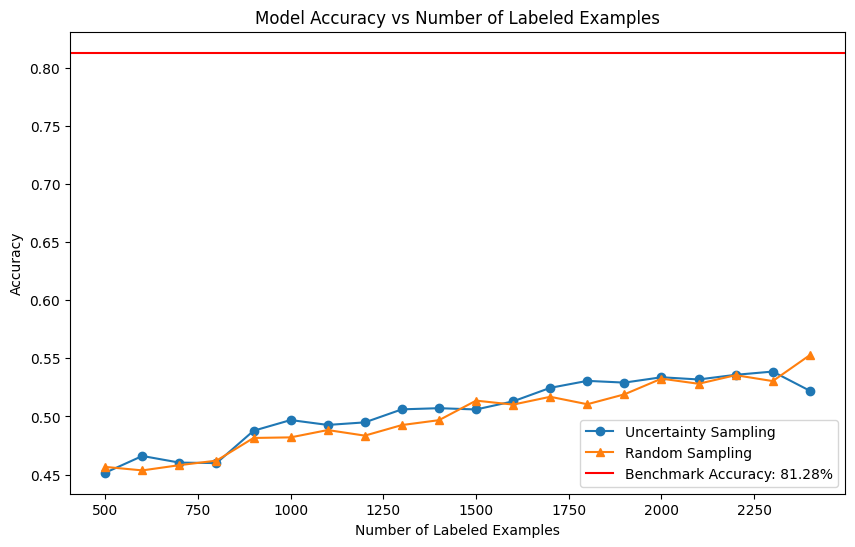

In [ ]:
import matplotlib.pyplot as plt

n = 1000  # Number of samples to query in each iteration
iterations = 49  # Number of iterations
# X-axis values representing the number of labeled examples seen so far
x_values_percentage = [(initial_train_size + n * i) / len(trainset) * 100 for i in range(iterations)]

plt.figure(figsize=(10, 6))

# Plot for Uncertainty Sampling
plt.plot(x_values, accuracies, label='Uncertainty Sampling', marker='o')

# Plot for Random Sampling (Baseline)
plt.plot(x_values, accuracies_random, label='Random Sampling', marker='^')

# Add a horizontal line for the benchmark accuracy
benchmark_accuracy = 81.28  # Benchmark accuracy
plt.axhline(y=benchmark_accuracy/100, color='r', linestyle='-', label=f'Benchmark Accuracy: {benchmark_accuracy}%')

# Add labels and legend
plt.xlabel('Number of Labeled Examples')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs Number of Labeled Examples')
plt.legend()

# Show the plot
plt.show()